In [1]:
from qTools import *
import Cahit as ck

import scipy.sparse as sp
import numpy as np

from functools import partial
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import datetime

import copy

In [2]:
resonatorDimension = 200
g = 1.79
qfreq = 0
resFreq = 2

In [3]:
qSim = Simulation()
qSim.finalTime = 1.2
qSim.stepSize = 0.02
JCSys = qSim.qSys
qSim.delState = True

In [4]:
cav = Cavity(dimension=resonatorDimension, frequency=resFreq)
JCSys.addSubSys(cav)

qub = JCSys.createSubSys(subClass=Qubit)
qub.frequency = qfreq

Cavity requires a dimension
{}
Qubit requires a dimension


In [5]:
digitalRabi = qProtocol(superSys=JCSys)
JCunitary = freeEvolution(ratio=0.5, superSys=JCSys)
bitFlip = xGate(implementation='instant', superSys=qub, fixed=True)
#AJC = freeEvolution(superSys=JCSys)
#qubset = JCunitary.createUpdate(system=qub, key='frequency', value=0)
digitalRabi.addStep(JCunitary, bitFlip, JCunitary, JCunitary, bitFlip, JCunitary)

JCSys.unitary = digitalRabi

In [6]:
JCcoupling = JCSys.JC(cav, qub, g)

In [7]:
RabiSys = JCSys.copy(name='Rabi')
RabiCoupling = RabiSys.Rabi(RabiSys.qSystems['Cavity2'],RabiSys.qSystems['Qubit2'], g)
qSim.subSystems = RabiSys

Cavity requires a dimension
{'dimension': 2, 'frequency': 0, 'operator': <function sigmaz at 0x11a0f6290>}
Qubit requires a dimension


In [8]:
JCSys.initialState = [0,0]

cavFreqSweep = qSim.Loop.addSweep(sys=cav, sweepKey='frequency')
cavFreqSweep.sweepList = np.arange(-4, 4+0.05, 0.05)

"""gSweep = qSim.beforeLoop.addSweep(sys=JCcoupling, sweepKey='couplingStrength')
gSweep.sweepList = np.arange(0, 2, 0.05)"""

"gSweep = qSim.beforeLoop.addSweep(sys=JCcoupling, sweepKey='couplingStrength')\ngSweep.sweepList = np.arange(0, 2, 0.05)"

In [9]:
# TODO copy should copy the initial state 
RabiSys.initialState = [0,0]

cavFreqSweep2 = qSim.Loop.addSweep(sys=RabiSys.qSystems['Cavity2'], sweepKey='frequency')
cavFreqSweep2.sweepList = np.arange(-8, 8+0.1, 0.1)

In [10]:
cavParity = parityEXP(cav.freeMat)
qubPop = qub.freeMat

def expect(qSim, state1, state2):
    qSim.qRes.result = expectationKet(cavParity, state1)
    qSim.qRes.result = fidelityKet(state1, state2)

qSim.compute = expect

In [11]:
nw = datetime.datetime.now()

results = qSim.run(p=True, coreCount='all')

en = datetime.datetime.now()

print(en-nw)

0:00:31.590879


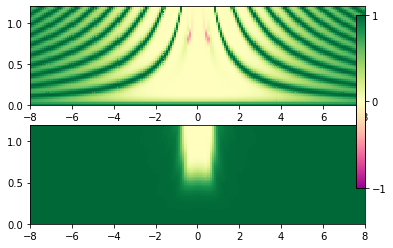

In [12]:
def plotRes(xList = cavFreqSweep2.sweepList):
    fig = plt.figure()
    setC = [0.88, 0.25, 0.02, 0.6]
    axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], results.results[0],ax=axGrids[0], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], results.results[1],ax=axGrids[1], gif=fig, setC=setC)
plotRes()

In [13]:
JCSys.reset()
JCSys.createSysCoupling([qub,cav],[QuantumToolbox.operators.sigmax, QuantumToolbox.operators.create], couplingStrength=g)
JCSys.createSysCoupling([cav, qub],[QuantumToolbox.operators.destroy, QuantumToolbox.operators.sigmax], couplingStrength=g)
JCSys.couplingName = 'Rabi'

In [14]:
# TODO remove corresponding sweeps
qSim.removeSys(RabiSys)

def expectn(qSim, state1):
    qSim.qRes.result = expectationKet(cavParity, state1)
    qSim.qRes.result = fidelityKet(qSim.qSys.initialState, state1)

qSim.compute = expectn

0:00:24.189631


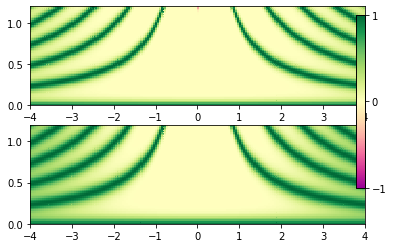

In [15]:
#p1 = Pool(processes=cpu_count())
nw = datetime.datetime.now()

results = qSim.run()

en = datetime.datetime.now()
print(en-nw)
plotRes(cavFreqSweep.sweepList)

0:00:08.768191


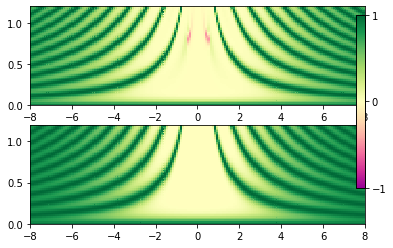

In [16]:
JCSys.reset(to='JC')

nw = datetime.datetime.now()

results = qSim.run(p=True, coreCount='all')

en = datetime.datetime.now()
print(en-nw)
plotRes(cavFreqSweep2.sweepList)

In [17]:
JCSys.reset(to='JC')

cavFreqSweep.sweepList = np.arange(-2, 2+0.025, 0.025)
JCSys.unitary = [freeEvolution(superSys=JCSys), digitalRabi]

In [18]:
def expectm(qSim, state1, state2):
    qSim.qRes.result = expectationKet(cavParity, state1)
    qSim.qRes.result = expectationKet(cavParity, state2)

qSim.compute = expectm

0:00:57.018325


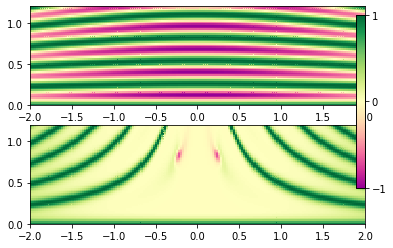

In [19]:
nw = datetime.datetime.now()

results = qSim.run(p=False)

en = datetime.datetime.now()
print(en-nw)
plotRes(cavFreqSweep.sweepList)

In [ ]:
JCSys.reset(to='JC')
